<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/Tae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

In [ ]:
!pip install librosa pydub torchaudio snntorch tqdm matplotlib seaborn torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
# Libreria standard
import os                               # file e cartelle
import numpy as np                      # operazioni matriciali, audio e spet sono matrici
import pandas as pd                     # leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         # grafici std
import seaborn as sns                   # grafici statistici più belli

# Audio
import librosa                          # per audio in python, calcola features ecc
import librosa.display                  # visualizzare spettrogrammi
import torchaudio                       # audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       # Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          # gestire audio a livello più "umano"

# Deep learning e SNN
import torch                            # costruzioni reti neurali
import snntorch as snn                  # estensione pytorch per SNN
import snntorch.functional as SF
from snntorch import spikegen           # converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 # costruzione e training di modelli di ml e dl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from torchinfo import summary
from snntorch import surrogate, functional

# Altri
from tqdm import tqdm                   # aggiungere barre di progresso ai loop, quanto manca al caricamento audio
from torch.utils.data import Dataset    # Dataset class
from torch.utils.data import DataLoader # DataLoader class
from enum import Enum
import time
import itertools
import json
import datetime
from itertools import product
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, precision_score, recall_score


In [ ]:
print("GPU disponibile:", tf.config.list_physical_devices('GPU'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Userai:", device)

GPU disponibile: []
Userai: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Uploading CSV

In [ ]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)

In [ ]:
%ls /content/drive/MyDrive/HumanData/ESC-10/

chainsaw/    crackling_fire/  dog/         rain/     sea_waves/
clock_tick/  crying_baby/     helicopter/  rooster/  sneezing/


### Processare tutti i file audio

In [ ]:
BASE_PATH = '/content/drive/MyDrive/HumanData/ESC-10'
SAMPLE_RATE = 44100  # non fare downsampling
N_MELS = 128
N_FFT = 1024
HOP_LENGTH = 512
DURATION = 5.0       # lunghezza standard (secondi)
BATCH_SIZE = 32

class ESCLabels(Enum):
    chainsaw = 0
    clock_tick = 1
    crackling_fire = 2
    crying_baby = 3
    dog = 4
    helicopter = 5
    rain = 6
    rooster = 7
    sea_waves = 8
    sneezing = 9



class_names = [
    'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
    'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
]

In [ ]:
def load_audio_file(file_path, sr=SAMPLE_RATE, duration=5.0, top_db = 30):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    #y, _ = librosa.effects.trim(y, top_db=top_db)           # elimina silence iniziale e finale
    y = librosa.util.normalize(y)           # normalizzazione RMS
    #if len(y) < int(sr * duration):
    #    padding = int(sr * duration) - len(y)
    #    y = np.pad(y, (0, padding))         # padding se troppo corto
    return y

Controllo di quanto silenzio tolgo

In [ ]:
# total_trimmed_start = 0.0
# total_trimmed_end = 0.0
# clip_count = 0

# for label in sorted(os.listdir(BASE_PATH)):
#     class_path = os.path.join(BASE_PATH, label)
#     for file in os.listdir(class_path):
#         if file.endswith(".wav"):
#             file_path = os.path.join(class_path, file)

#             # Carica audio
#             y, sr = librosa.load(file_path, sr=44100, duration=5.0)

#             # Applica trim
#             y_trimmed, index = librosa.effects.trim(y, top_db=30)
#             start_sample, end_sample = index

#             # Converti in secondi
#             start_sec = start_sample / sr
#             end_sec = (len(y) - end_sample) / sr

#             total_trimmed_start += start_sec
#             total_trimmed_end += end_sec
#             clip_count += 1

#             print(f"{file} → Trim: start={start_sec:.2f}s, end={end_sec:.2f}s")

# # Statistiche finali
# print("\n--- STATISTICHE TOTALI ---")
# print(f"Clip analizzati: {clip_count}")
# print(f"Silenzio medio INIZIALE tagliato: {total_trimmed_start / clip_count:.2f} s")
# print(f"Silenzio medio FINALE tagliato: {total_trimmed_end / clip_count:.2f} s")


In [ ]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(BASE_PATH))  # lista classi ordinate
print(labels, "\n")
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(BASE_PATH, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'] 



Caricamento Audio: 100%|██████████| 10/10 [02:43<00:00, 16.34s/it]


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.4, random_state=42, stratify=y_labels)

# Poi dividi temp in val e test (50/50 => 15% ciascuno)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 240, Val: 80, Test: 80


## NAA

In [ ]:
def center_crop(signal, target_len):
    if len(signal) < target_len:
        pad_left = (target_len - len(signal)) // 2
        pad_right = target_len - len(signal) - pad_left
        return np.pad(signal, (pad_left, pad_right), mode='constant')
    else:
        start = (len(signal) - target_len) // 2
        return signal[start:start + target_len]

In [ ]:
def naa(y, sr):
    augmented = []
    target_len = int(sr * 5.0)

    # Originale
    augmented.append(center_crop(y, target_len))

    # Pitch shift
    augmented.append(center_crop(librosa.effects.pitch_shift(y, sr=sr, n_steps=+2), target_len))
    augmented.append(center_crop(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2), target_len))

    # Time stretch
    for rate in [0.7, 1.2]:
        y_stretched = librosa.effects.time_stretch(y, rate=rate)
        augmented.append(center_crop(y_stretched, target_len))

    return augmented

In [ ]:
X_train_aug = []
y_train_aug = []

for i in tqdm(range(len(X_train)), desc="NAA"):
    original_audio = X_train[i]
    label = y_train[i]

    # Applica la tua funzione naa → restituisce 5 versioni (incluso l'originale)
    augmented_audios = naa(original_audio, sr=SAMPLE_RATE)

    # Aggiungi tutte le versioni alla lista finale
    X_train_aug.extend(augmented_audios)
    y_train_aug.extend([label] * len(augmented_audios))

In [ ]:
# Calcola le lunghezze di tutti gli audio
lengths = [len(x) for x in X_train_aug]

# Trova il minimo e il massimo
min_len = min(lengths)
max_len = max(lengths)

# Converti in secondi (facoltativo)
min_sec = min_len / SAMPLE_RATE
max_sec = max_len / SAMPLE_RATE

print(f"Audio più corto: {min_len} samples ({min_sec:.2f} s)")
print(f"Audio più lungo: {max_len} samples ({max_sec:.2f} s)")

## Converti in log-Mel

In [ ]:
def preprocess_audio(y, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
  #Calcolare Mel-spectrogram
  y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  #Convertire in Log
  y_mel = librosa.power_to_db(y_mel, ref=np.max)    #calcola i db rispetto al valore massimo nel Mel-spect.

  return y_mel

In [ ]:
def clip_silent_frames(mel, threshold_db=-70.0):
    silent_mask = np.all(mel < threshold_db, axis=0)
    mel[:, silent_mask] = threshold_db  # o np.mean(mel)
    return mel

'\ndef clip_silent_frames(mel, threshold_db=-70.0):\n    silent_mask = np.all(mel < threshold_db, axis=0)\n    mel[:, silent_mask] = threshold_db  # o np.mean(mel)\n    return mel\n'

In [ ]:
def batch_logmel(X, sr=SAMPLE_RATE):
    mel_list = []
    for x in tqdm(X, desc="Log-Mel"):
        mel = preprocess_audio(x, sr=sr)
        # mel = clip_silent_frames(mel)
        mel_list.append(mel)
    return mel_list

In [ ]:
X_train_mel = batch_logmel(X_train_aug)
X_val_mel = batch_logmel(X_val)
X_test_mel = batch_logmel(X_test)

"""
X_train_mel = batch_logmel(X_train)
X_val_mel = batch_logmel(X_val)
X_test_mel = batch_logmel(X_test)
"""

Log-Mel: 100%|██████████| 80/80 [00:03<00:00, 23.30it/s]


In [ ]:
print("Train set:", len(X_train_mel))
print("Val set:", len(X_val_mel))
print("Test set:", len(X_test_mel))

print("Shape primo sample train:", X_train_mel[0].shape)

Train set: 240
Val set: 80
Test set: 80
Shape primo sample train: (128, 431)


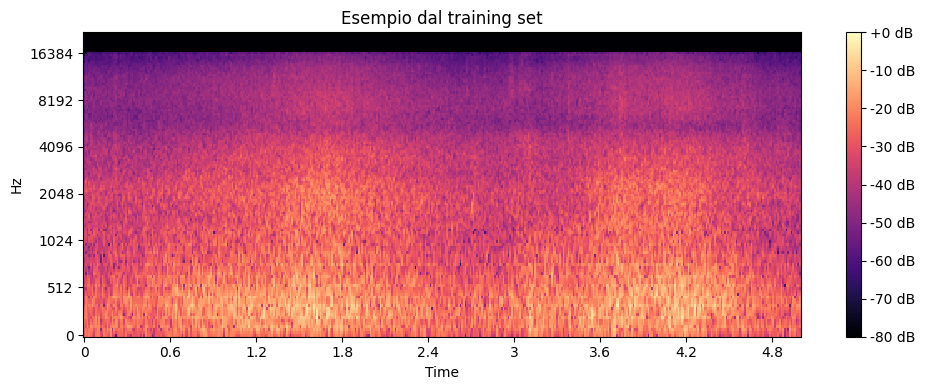

Class:  sea_waves


In [ ]:
def show_mel(mel, title="Log-Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualizza un esempio a caso dal training set
sample_idx = 32
show_mel(X_train_mel[sample_idx], title="Esempio dal training set")
print("Class: ", ESCLabels(y_train[sample_idx]).name)


In [ ]:
all_vals = np.concatenate([mel.flatten() for mel in X_train_mel])
print("Min:", np.min(all_vals))
print("Max:", np.max(all_vals))

Min: -80.0
Max: 0.0


In [ ]:
def pad_to_multiple_of(mel, multiple=50, value=-80.0):
    # Pads mel spectrogram along time axis to make time frames a multiple of 'multiple'
    current_len = mel.shape[1]
    target_len = ((current_len + multiple - 1) // multiple) * multiple
    pad_width = target_len - current_len
    return np.pad(mel, ((0, 0), (0, pad_width)), mode='constant', constant_values=value)


In [ ]:
# Applica padding a multiplo di 50 (compatibile con timesteps=50)
X_train_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_train_mel]
X_val_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_val_mel]
X_test_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_test_mel]


In [ ]:
print("Train shape esempio:", X_train_mel[0].shape)
print("Val shape esempio:", X_val_mel[0].shape)
print("Test shape esempio:", X_test_mel[0].shape)

Train shape esempio: (128, 431)
Val shape esempio: (128, 431)
Test shape esempio: (128, 431)


In [ ]:
X_train_mel_np = np.array(X_train_mel)
X_val_mel_np = np.array(X_val_mel)
X_test_mel_np = np.array(X_test_mel)

if len(X_train_mel_np.shape) == 3:
    X_train_mel_np = X_train_mel_np[..., np.newaxis]  # (N, 64, 431, 1)

#y_train_np = np.array(y_train_aug)  # Etichette corrispondenti
y_train_np = np.array(y_train)

Normalizzazione

In [ ]:
X_train_mel_np = (X_train_mel_np + 80.0) / 80.0
X_val_mel_np = (X_val_mel_np + 80.0) / 80.0
X_test_mel_np = (X_test_mel_np + 80.0) / 80.0

## TAA

In [ ]:
"""
taa_generator = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    shear_range=0.3,
    fill_mode='nearest'
)
"""

In [ ]:
"""
X_taa = []
y_taa = []

augmentations_per_sample = 4  # puoi aumentare questo numero

for i in tqdm(range(len(X_train_mel_np)), desc="TAA Augmentation"):
    sample = X_train_mel_np[i]  # shape: (64, max_len, 1)
    sample = np.expand_dims(sample, axis=0)  # shape: (1, 64, max_len, 1)

    # Genera augmentazioni
    gen = taa_generator.flow(sample, batch_size=1)
    for _ in range(augmentations_per_sample):
        aug_sample = next(gen)[0]  # shape: (64, max_len, 1)
        X_taa.append(aug_sample)
        y_taa.append(y_train_np[i])

# Combina con il training set originale
X_train_augmented = np.concatenate([X_train_mel_np, np.array(X_taa)], axis=0)
y_train_augmented = np.concatenate([y_train_np, np.array(y_taa)], axis=0)

print("Nuova shape X:", X_train_augmented.shape)
print("Nuova shape y:", y_train_augmented.shape)
"""

## Converto in tensori

In [ ]:
# Augmented Data
"""
X_train = torch.from_numpy(X_train_augmented).float()
X_val = torch.from_numpy(X_val_mel_np).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_train = torch.from_numpy(y_train_augmented).long()
y_val = torch.from_numpy(np.array(y_val)).long()
y_test = torch.from_numpy(np.array(y_test)).long()
"""
# Non Augmented Daya
X_train = torch.from_numpy(X_train_mel_np).float()
X_val = torch.from_numpy(X_val_mel_np).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_train = torch.from_numpy(y_train_np).long()
y_val = torch.from_numpy(np.array(y_val)).long()
y_test = torch.from_numpy(np.array(y_test)).long()

In [ ]:
print("Shape X_train:", X_train.shape)
print("Tipo dati:", X_train.dtype)
print("Valori min/max:", torch.min(X_train), torch.max(X_train))

Shape X_train: torch.Size([240, 128, 431, 1])
Tipo dati: torch.float32
Valori min/max: tensor(0.) tensor(1.)


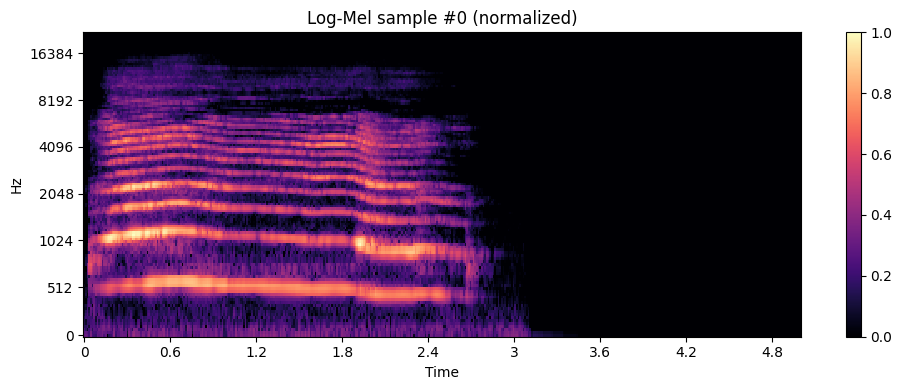

Class: crying_baby


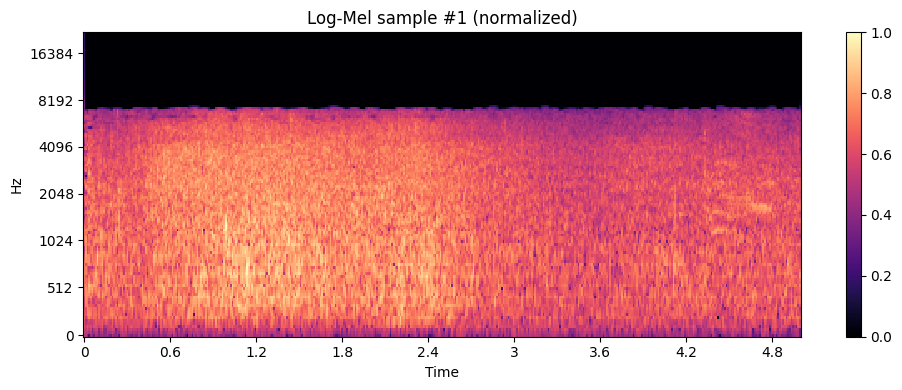

Class: sea_waves


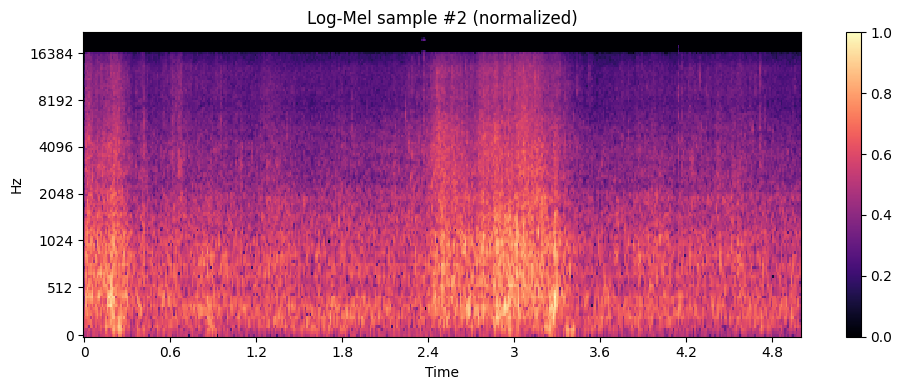

Class: sea_waves


In [ ]:
def show_mel_sample(index):
    mel = X_train[index].numpy().squeeze()  # converti tensore in NumPy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar()  # non usare '%+2.0f dB' perché ora i valori sono [0, 1]
    plt.title(f"Log-Mel sample #{index} (normalized)")
    plt.tight_layout()
    plt.show()
    print("Class:", ESCLabels(y_train[index].item()).name)

for i in range(3):
    show_mel_sample(i)

In [ ]:
print("y_train shape:", y_train.shape)
print("Etichette uniche:", np.unique(y_train))

# Stampa etichetta di un esempio
for i in range(3):
    print(f"Esempio {i}: label = {y_train[i]}")

y_train shape: torch.Size([240])
Etichette uniche: [0 1 2 3 4 5 6 7 8 9]
Esempio 0: label = 3
Esempio 1: label = 8
Esempio 2: label = 8


# Spike Encoding

In [ ]:
def visualize_spike_trains(spike_tensor, sample_idx=0, mel_bin=10):
    """
    Visualizes delta spike encodings with three plots:
    1. Full raster plot of all mel bins
    2. Single mel bin spike train with vertical lines
    3. Density plot showing balance between positive and negative spikes

    Args:
      spike_tensor : torch.Tensor or list
          The delta spike tensor. Expected shape: [batch_size, time_frames, n_mels]
          If from DataLoader, expected to be a list containing tensors
      sample_idx : int
          Index of the sample in the batch to visualize
      mel_bin : int
          Which mel frequency bin to visualize in the spike train plot
    """

    # Check if input is a list (from DataLoader) or direct tensor
    if isinstance(spike_tensor, list):
        spikes = spike_tensor[0].squeeze(-1)[sample_idx].detach().cpu().numpy()
    elif isinstance(spike_tensor, torch.Tensor):
        # If 4D tensor [batch_size, time_frames, n_mels]
        if len(spike_tensor.shape) == 3:
            spikes = spike_tensor.squeeze(-1)[sample_idx, :, :].detach().cpu().numpy()
        else:
            raise ValueError(f"Unexpected spike tensor shape: {spike_tensor.shape}")
    else:
        raise TypeError("spike_tensor must be a torch.Tensor or a list containing tensors")

    if len(spikes.shape) > 2:
        spikes = spikes.squeeze()

    pos_spikes = (spikes > 0).astype(float)
    neg_spikes = (spikes < 0).astype(float)

    plt.figure(figsize=(10, 12))

    # 1. Raster Plot with Inverted Y-axis
    plt.subplot(3, 1, 1)
    plt.imshow(spikes.T, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1, origin='lower')
    plt.colorbar(ticks=[-1, 0, 1], label='Spike Type')
    plt.title("Full Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Mel Bin")
    num_mel_bins = spikes.shape[1]
    tick_interval = max(1, num_mel_bins // 7)
    plt.yticks(np.arange(0, num_mel_bins, tick_interval))

    # 2. Single Mel Bin Spike Train with vlines
    plt.subplot(3, 1, 2)
    pos_times = np.where(spikes[:, mel_bin] == 1)[0]
    neg_times = np.where(spikes[:, mel_bin] == -1)[0]
    plt.vlines(pos_times, 0, 1, color='red', linewidth=0.8)
    plt.vlines(neg_times, -1, 0, color='blue', linewidth=0.8)
    plt.yticks([-1, 0, 1])
    plt.ylim(-1.2, 1.2)
    plt.title(f"Spike Train for Mel Bin {mel_bin}")
    plt.xlabel("Time Step")
    plt.ylabel("Spike Value")
    plt.grid(False)
    legend_elements = [plt.Line2D([0], [0], color='red', lw=2, label='Positive Spikes'),
                      plt.Line2D([0], [0], color='blue', lw=2, label='Negative Spikes')]
    plt.legend(handles=legend_elements)

    # 3. Density Plot with Legend
    plt.subplot(3, 1, 3)
    plt.stackplot(np.arange(spikes.shape[0]),
                  pos_spikes.sum(axis=1),
                  -neg_spikes.sum(axis=1),
                  colors=['red', 'blue'])

    plt.legend(['Positive Spikes', 'Negative Spikes'])
    plt.title("Spike Polarity Balance Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Net Spike Count")

    plt.tight_layout()
    plt.show()

# TAE

In [ ]:
class ThresholdAdaptiveEncoding(Dataset):

  def __init__(self, X, y, alpha=0.9, threshold=0.05):
    self.X = X
    self.y = y
    self.alpha = alpha
    self.threshold = threshold

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    x = self.X[idx].squeeze(-1)  # [n_mels, time_steps]
    y = self.y[idx]

    spike_train = torch.zeros(
        x.shape[1], x.shape[0], dtype=torch.int8
    )  # [time_steps, n_mels]

    for mel_idx in range(x.shape[0]):
      spike_train[:, mel_idx] = self._encode_tae(x[mel_idx])

    return spike_train, y.long()

  def _encode_tae(self, signal):
    """
    Encode a signal using the Threshold Adaptive Encoding (TAE) algorithm.

    Args:
        signal: 1D tensor or 2D tensor of shape [1, N]

    Returns:
        1D tensor of encoded spikes with values in {-1, 0, 1}
    """
    if signal.dim() == 2:
        signal = signal.squeeze(0)  # ensure shape [N]

    signal_np = signal.numpy()
    spikes = np.zeros_like(signal_np, dtype=np.int8)

    base = signal_np[0]
    threshold = self.threshold  # use instance value
    alpha = self.alpha          # decay factor

    for i in range(1, len(signal_np)):
        diff = signal_np[i] - base
        if diff >= threshold:
            spikes[i] = 1
            base += threshold
            threshold *= alpha
        elif diff <= -threshold:
            spikes[i] = -1
            base -= threshold
            threshold *= alpha
        else:
            threshold *= alpha

    return torch.from_numpy(spikes)

In [ ]:
ALPHA = 0.999

tae_train_dataset = ThresholdAdaptiveEncoding(
    X_train, y_train,
    alpha=ALPHA
)

tae_val_dataset = ThresholdAdaptiveEncoding(
    X_val, y_val,
    alpha=ALPHA
)

tae_test_dataset = ThresholdAdaptiveEncoding(
    X_test, y_test,
    alpha=ALPHA
)

# Create TAE dataloaders
tae_train_dataloader = DataLoader(
    dataset=tae_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

tae_val_dataloader = DataLoader(
    dataset=tae_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

tae_test_dataloader = DataLoader(
    dataset=tae_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

# Test the TAE encoding
print("Testing Threshold Adaptive Encoding...")
tae_x_batch, tae_y_batch = next(iter(tae_train_dataloader))
print(f"TAE batch shape: {tae_x_batch.shape}")

In [ ]:
sample_idx = 10
visualize_spike_trains(spike_tensor=tae_x_batch, sample_idx=sample_idx, mel_bin=10)
print(f"TAE Class: {ESCLabels(tae_y_batch[sample_idx].item()).name}")

# Modelling

## Simple SNN

In [ ]:
class SNNClassifier(torch.nn.Module):
    def __init__(
        self,
        n_mels,
        hidden_sizes,
        num_classes,
        surr_grad,
        learn_thr=True,
        learn_beta=True,
    ):
        super(SNNClassifier, self).__init__()
        self.n_mels = n_mels
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.surr_grad = surr_grad
        self.learn_thr = learn_thr
        self.learn_beta = learn_beta

        # Layer 1: Input to Hidden 1
        self.fc1 = torch.nn.Linear(n_mels, self.hidden_sizes[0])
        self.lif1 = snn.Leaky(
            beta=torch.full((self.hidden_sizes[0],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 2: Hidden 1 to Hidden 2
        self.fc2 = torch.nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1])
        self.lif2 = snn.Leaky(
            beta=torch.full((self.hidden_sizes[1],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 3: Hidden 2 to Hidden 3
        self.fc3 = torch.nn.Linear(self.hidden_sizes[1], self.hidden_sizes[2])
        self.lif3 = snn.Leaky(
            beta=torch.full((self.hidden_sizes[2],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Output Layer
        self.fc_out = torch.nn.Linear(self.hidden_sizes[2], num_classes)
        self.lif_out = snn.Leaky(
            beta=torch.full((num_classes,), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism='zero',
        )

    def forward(self, x):
        batch_size, time_steps, _ = x.shape

        # Initialize membrane potentials
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem_out = self.lif_out.init_leaky()

        spk_rec = []
        mem_rec = []

        for step in range(time_steps):
            x_t = x[:, step, :]

            cur1 = self.fc1(x_t)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            cur_out = self.fc_out(spk3)
            spk_out, mem_out = self.lif_out(cur_out, mem_out)

            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

## TRAINING

In [ ]:
def train_fn(model, train_loader, valid_loader, accuracy, loss_fn, optimizer,
             epochs, patience, path, verbose=True, max_batches=None):
    """
    Optimized training function with:
    - Optional batch limiting (for quick testing)
    - Mixed precision training
    - Reduced GPU memory usage
    - Progress tracking
    """
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []
    counter = 0
    best_val_loss = float('inf')

    # Enable mixed precision training if available
    scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

    for epoch in tqdm(range(epochs), desc="Epochs"):
        start_time = time.time()

        # Training mode
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for batch_idx, (X, y) in enumerate(tqdm(train_loader, desc="Train batches", leave=False, total=len(train_loader))):
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            optimizer.zero_grad(set_to_none=True)

            # Use mixed precision where available
            if scaler:
                with torch.cuda.amp.autocast():
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                # Scale gradients and optimize
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                spk_out, _ = model(X.float())
                acc = accuracy(spk_out, y)
                loss = loss_fn(spk_out, y)
                loss.backward()
                optimizer.step()

            train_acc += acc.item()
            train_loss += loss.item()

            # Free up memory
            del X, y, spk_out, loss, acc

        # Calculate average metrics
        train_loss_avg = train_loss / len(train_loader)
        train_acc_avg = train_acc / len(train_loader)
        train_loss_list.append(train_loss_avg)
        train_acc_list.append(train_acc_avg)

        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0

        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(valid_loader):
                X = X.squeeze().to(device)
                y = y.squeeze().long().to(device)

                # Forward pass with reduced memory usage
                if scaler:
                    with torch.cuda.amp.autocast():
                        spk_out, _ = model(X.float())
                        acc = accuracy(spk_out, y)
                        loss = loss_fn(spk_out, y)
                else:
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                val_acc += acc.item()
                val_loss += loss.item()

                # Free up memory
                del X, y, spk_out, loss, acc

        # Calculate validation metrics
        val_loss_avg = val_loss / len(valid_loader)
        val_acc_avg = val_acc / len(valid_loader)
        val_loss_list.append(val_loss_avg)
        val_acc_list.append(val_acc_avg)

        # Early stopping logic
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            counter = 0
            if path:
                #torch.save(model.state_dict(), path)
                pass
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping triggered")
            break

        torch.cuda.empty_cache()
        end_time = time.time()

        if verbose:
            print(f"\nEpoch {epoch+1}/{epochs} - {int(end_time-start_time)}s - "
                  f"loss: {train_loss_avg:.4f} - acc: {train_acc_avg:.4f} - "
                  f"val_loss: {val_loss_avg:.4f} - val_acc: {val_acc_avg:.4f}")

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

## Evalutation

In [ ]:
# Valutazione nel test set
def evaluate_model_comprehensive(model, dataloader, class_names, device):
    """
    Comprehensive evaluation function that computes accuracy, F1, precision, and recall.
    Now handles zero-division gracefully and reports classes with no predictions.
    Enhanced confusion matrix shows percentages for each cell.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            spk_out, _ = model(X.float())
            spk_sum = spk_out.sum(dim=0)  # [batch_size, num_classes]
            preds = torch.argmax(spk_sum, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Identify classes never predicted
    missing = set(range(len(class_names))) - set(np.unique(all_preds))
    if missing:
        print("WARNING: The following classes were never predicted:",
              [class_names[i] for i in sorted(missing)])

    # Calculate accuracy
    accuracy = (all_preds == all_labels).mean()

    # Macro and weighted metrics with zero_division=0
    f1_macro    = f1_score(all_labels, all_preds, average='macro',    zero_division=0)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    precision_macro    = precision_score(all_labels, all_preds, average='macro',    zero_division=0)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)

    recall_macro    = recall_score(all_labels, all_preds, average='macro',    zero_division=0)
    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Per-class metrics
    f1_per_class        = f1_score(all_labels, all_preds, average=None, zero_division=0)
    precision_per_class = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall_per_class    = recall_score(all_labels, all_preds, average=None, zero_division=0)

    # Print summary
    print("="*60)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*60)
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

    print("MACRO AVERAGES:")
    print(f"  F1-Score   : {f1_macro:.4f}")
    print(f"  Precision  : {precision_macro:.4f}")
    print(f"  Recall     : {recall_macro:.4f}\n")

    print("WEIGHTED AVERAGES:")
    print(f"  F1-Score   : {f1_weighted:.4f}")
    print(f"  Precision  : {precision_weighted:.4f}")
    print(f"  Recall     : {recall_weighted:.4f}\n")

    print("PER-CLASS METRICS:")
    print("-" * 60)
    print(f"{'Class':<15} {'F1':<8} {'Precision':<10} {'Recall':<8}")
    print("-" * 60)
    for i, name in enumerate(class_names):
        print(f"{name:<15} "
              f"{f1_per_class[i]:<8.4f} "
              f"{precision_per_class[i]:<10.4f} "
              f"{recall_per_class[i]:<8.4f}")

    # Detailed report
    print("\n" + "="*60)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4,
        zero_division=0
    ))

    # Enhanced Confusion Matrix with percentages
    cm = confusion_matrix(all_labels, all_preds)

    # Create percentage matrix (normalize by row - true class)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    # Handle division by zero (classes with no samples)
    cm_percentage = np.nan_to_num(cm_percentage)

    # Create the enhanced confusion matrix plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: Standard confusion matrix with counts
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp1.plot(ax=ax1, cmap="Blues", xticks_rotation=45)
    ax1.set_title("Confusion Matrix - Counts", fontsize=14, fontweight='bold')

    # Plot 2: Enhanced confusion matrix with percentages
    im = ax2.imshow(cm_percentage, interpolation='nearest', cmap='Blues')
    ax2.figure.colorbar(im, ax=ax2)
    ax2.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            xticklabels=class_names, yticklabels=class_names,
            title="Confusion Matrix - Percentages (Row-wise)",
            ylabel='True label',
            xlabel='Predicted label')

    # Rotate the tick labels and set their alignment
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add text annotations with both count and percentage
    fmt = '.1f'
    thresh = cm_percentage.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Display both count and percentage
            text = f'{cm[i, j]}\n({cm_percentage[i, j]:.1f}%)'
            ax2.text(j, i, text,
                    ha="center", va="center",
                    color="white" if cm_percentage[i, j] > thresh else "black",
                    fontsize=10, fontweight='bold')

    ax2.set_title("Confusion Matrix - Counts & Percentages", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Additional analysis: Print per-class accuracy breakdown
    print("\n" + "="*60)
    print("PER-CLASS ACCURACY BREAKDOWN")
    print("="*60)
    print(f"{'True Class':<15} {'Correct':<8} {'Total':<8} {'Accuracy':<10}")
    print("-" * 60)

    for i, name in enumerate(class_names):
        correct = cm[i, i]  # Diagonal elements
        total = cm[i, :].sum()  # Total samples for this true class
        class_accuracy = correct / total * 100 if total > 0 else 0
        print(f"{name:<15} {correct:<8} {total:<8} {class_accuracy:<10.2f}%")

    # Create a third plot showing only the diagonal accuracy
    fig, ax3 = plt.subplots(figsize=(10, 6))
    class_accuracies = []
    for i in range(len(class_names)):
        correct = cm[i, i]
        total = cm[i, :].sum()
        acc = correct / total * 100 if total > 0 else 0
        class_accuracies.append(acc)

    bars = ax3.bar(class_names, class_accuracies, color='skyblue', alpha=0.7)
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    ax3.set_ylim(0, 100)
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracies):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

    # Add horizontal line for overall accuracy
    ax3.axhline(y=accuracy*100, color='red', linestyle='--', alpha=0.7,
                label=f'Overall Accuracy: {accuracy*100:.1f}%')
    ax3.legend()

    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_per_class': f1_per_class,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'confusion_matrix': cm,
        'confusion_matrix_percentage': cm_percentage,
        'per_class_accuracy': class_accuracies
    }

In [ ]:
hidden_sizes = [128, 128, 128]
num_classes = 10

snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(snn_classifier, input_size=(32, 1, N_MELS))

In [ ]:
patience = 30
num_epochs = 100
optimizer = torch.optim.Adam(snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=snn_classifier,
    train_loader=tae_train_dataloader,
    valid_loader=tae_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

In [ ]:
# Plot loss
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

results = evaluate_model_comprehensive(snn_classifier, tae_test_dataloader, class_names, device)

## CSNN

In [ ]:

class C_SNN(torch.nn.Module):
    def __init__(
        self,
        surr_grad,
        n_mels: int = 128,
        num_classes: int = 10,
        conv_channels1: int = 8,
        kernel_size: int = 3,
        pool_kernel: int = 2,
        dropout_rate: float = 0.15
    ):
        super().__init__()
        self.surr_grad = surr_grad

        # --- First Spiking Convolutional Block ---
        self.conv1 = torch.nn.Conv1d(
            in_channels=1,
            out_channels=conv_channels1,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            bias=False,
        )
        self.lif1 = snn.Leaky(
            beta=0.9,
            threshold=1.0,
            learn_beta=True,
            learn_threshold=True,
            spike_grad=surr_grad
        )
        self.pool1 = torch.nn.MaxPool1d(kernel_size=pool_kernel)

        # --- Fully Connected Layer ---
        freq_after_pool = n_mels // pool_kernel
        self.flattened_size = conv_channels1 * freq_after_pool

        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.fc1 = torch.nn.Linear(self.flattened_size, num_classes, bias=False)
        self.lif_out = snn.Leaky(
            beta=0.9,
            threshold=1.0,
            learn_beta=True,
            learn_threshold=True,
            spike_grad=surr_grad
        )

    def forward(self, spikes: torch.Tensor):
        """
        spikes: [batch_size, time_steps, n_mels]
        Returns:
            spk_rec: [time_steps, batch_size, num_classes]
            mem_rec: [time_steps, batch_size, num_classes]
        """
        B, T, F = spikes.shape

        mem1 = self.lif1.init_leaky()
        mem_out = self.lif_out.init_leaky()

        spk_rec = []
        mem_rec = []

        spikes_tm = spikes.permute(1, 0, 2)  # [T, B, F]

        for t in range(T):
            x_t = spikes_tm[t].unsqueeze(1)  # [B, 1, F]

            # --- Conv Block 1 ---
            x = self.conv1(x_t)
            spk1, mem1 = self.lif1(x, mem1)
            x = self.pool1(spk1)

            # --- Flatten + FC ---
            x = x.view(B, -1)
            x = self.dropout(x)
            x = self.fc1(x)
            spk_out, mem_out = self.lif_out(x, mem_out)

            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        spk_rec = torch.stack(spk_rec, dim=0)
        mem_rec = torch.stack(mem_rec, dim=0)

        return spk_rec, mem_rec

In [ ]:
c_snn_model = C_SNN(
    surr_grad=snn.surrogate.fast_sigmoid(),
    n_mels=N_MELS,
    num_classes=10,
    conv_channels1=8,
    conv_channels2=8,
    dropout_rate=0.0,
    kernel_size=3,
    pool_kernel=2
).to(device)

summary(c_snn_model, input_size=(BATCH_SIZE, 1, N_MELS))

In [ ]:
patience = 30
num_epochs = 100
optimizer = torch.optim.Adam(c_snn_model.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=c_snn_model,
    train_loader=tae_train_dataloader,
    valid_loader=tae_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

In [ ]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

class_names = [
    'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
    'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
]


evaluate_model_comprehensive(c_snn_model, tae_test_dataloader, class_names, device)



# Complexity and Performance Evaluation

In [ ]:
from collections import defaultdict
import gc

class PerformanceProfiler:
    """
    Comprehensive performance profiler for SNN models
    """

    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.metrics = defaultdict(list)

    def profile_inference(self, dataloader, num_batches=None, warmup_batches=3):
        """
        Profile inference performance with detailed metrics
        """
        print("="*60)
        print("INFERENCE PERFORMANCE PROFILING")
        print("="*60)

        self.model.eval()

        # Metrics storage
        batch_times = []
        memory_usage = []
        gpu_memory = []
        cpu_usage = []

        total_samples = 0
        total_batches = 0

        # GPU memory tracking (if available)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(dataloader):
                if num_batches and batch_idx >= num_batches + warmup_batches:
                    break

                X = X.squeeze().to(self.device)
                y = y.squeeze().long().to(self.device)

                # Start timing after warmup
                if batch_idx >= warmup_batches:
                    torch.cuda.synchronize() if torch.cuda.is_available() else None
                    start_time = time.perf_counter()

                    # Memory before inference
                    process = psutil.Process()
                    cpu_mem_before = process.memory_info().rss / 1024**2  # MB
                    cpu_percent = psutil.cpu_percent(interval=None)

                # Forward pass
                spk_out, mem_out = self.model(X.float())

                if batch_idx >= warmup_batches:
                    torch.cuda.synchronize() if torch.cuda.is_available() else None
                    end_time = time.perf_counter()

                    # Record metrics
                    batch_time = end_time - start_time
                    batch_times.append(batch_time)

                    # Memory usage
                    cpu_mem_after = process.memory_info().rss / 1024**2  # MB
                    memory_usage.append(cpu_mem_after)
                    cpu_usage.append(cpu_percent)

                    if torch.cuda.is_available():
                        gpu_mem = torch.cuda.memory_allocated() / 1024**2  # MB
                        gpu_memory.append(gpu_mem)

                    total_samples += X.shape[0]
                    total_batches += 1

                # Cleanup
                del X, y, spk_out, mem_out

        # Calculate statistics
        batch_times = np.array(batch_times)
        memory_usage = np.array(memory_usage)
        cpu_usage = np.array(cpu_usage)

        results = {
            'batch_times': batch_times,
            'memory_usage': memory_usage,
            'cpu_usage': cpu_usage,
            'total_samples': total_samples,
            'total_batches': total_batches,
            'avg_batch_time': np.mean(batch_times),
            'std_batch_time': np.std(batch_times),
            'min_batch_time': np.min(batch_times),
            'max_batch_time': np.max(batch_times),
            'samples_per_second': total_samples / np.sum(batch_times),
            'avg_memory': np.mean(memory_usage),
            'peak_memory': np.max(memory_usage),
            'avg_cpu': np.mean(cpu_usage),
        }

        if torch.cuda.is_available():
            gpu_memory = np.array(gpu_memory)
            results.update({
                'gpu_memory': gpu_memory,
                'avg_gpu_memory': np.mean(gpu_memory),
                'peak_gpu_memory': np.max(gpu_memory),
                'pytorch_peak_memory': torch.cuda.max_memory_allocated() / 1024**2
            })

        return results

    def profile_training_step(self, train_loader, optimizer, loss_fn, accuracy_fn, num_batches=10):
        """
        Profile a few training steps to measure training performance
        """
        print("="*60)
        print("TRAINING PERFORMANCE PROFILING")
        print("="*60)

        self.model.train()

        # Enable mixed precision if available
        scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

        batch_times = []
        forward_times = []
        backward_times = []
        memory_usage = []
        gpu_memory = []

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

        for batch_idx, (X, y) in enumerate(train_loader):
            if batch_idx >= num_batches:
                break

            X = X.squeeze().to(self.device)
            y = y.squeeze().long().to(self.device)

            # Start timing
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            batch_start = time.perf_counter()

            optimizer.zero_grad(set_to_none=True)

            # Forward pass timing
            forward_start = time.perf_counter()
            if scaler:
                with torch.cuda.amp.autocast():
                    spk_out, _ = self.model(X.float())
                    acc = accuracy_fn(spk_out, y)
                    loss = loss_fn(spk_out, y)
            else:
                spk_out, _ = self.model(X.float())
                acc = accuracy_fn(spk_out, y)
                loss = loss_fn(spk_out, y)

            torch.cuda.synchronize() if torch.cuda.is_available() else None
            forward_end = time.perf_counter()
            forward_times.append(forward_end - forward_start)

            # Backward pass timing
            backward_start = time.perf_counter()
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            torch.cuda.synchronize() if torch.cuda.is_available() else None
            backward_end = time.perf_counter()
            backward_times.append(backward_end - backward_start)

            batch_end = time.perf_counter()
            batch_times.append(batch_end - batch_start)

            # Memory tracking
            process = psutil.Process()
            memory_usage.append(process.memory_info().rss / 1024**2)

            if torch.cuda.is_available():
                gpu_memory.append(torch.cuda.memory_allocated() / 1024**2)

            del X, y, spk_out, loss, acc

        results = {
            'batch_times': np.array(batch_times),
            'forward_times': np.array(forward_times),
            'backward_times': np.array(backward_times),
            'memory_usage': np.array(memory_usage),
            'avg_batch_time': np.mean(batch_times),
            'avg_forward_time': np.mean(forward_times),
            'avg_backward_time': np.mean(backward_times),
            'peak_memory': np.max(memory_usage),
        }

        if torch.cuda.is_available():
            results.update({
                'gpu_memory': np.array(gpu_memory),
                'peak_gpu_memory': np.max(gpu_memory),
                'pytorch_peak_memory': torch.cuda.max_memory_allocated() / 1024**2
            })

        return results

    def analyze_model_complexity(self):
        """
        Analyze model complexity metrics
        """
        print("="*60)
        print("MODEL COMPLEXITY ANALYSIS")
        print("="*60)

        # Count parameters
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)

        # Model size in MB
        param_size = 0
        buffer_size = 0

        for param in self.model.parameters():
            param_size += param.nelement() * param.element_size()

        for buffer in self.model.buffers():
            buffer_size += buffer.nelement() * buffer.element_size()

        model_size_mb = (param_size + buffer_size) / 1024**2

        # Memory estimate for different batch sizes
        def estimate_memory(batch_size, time_steps=450, n_mels=128):
            # Input tensor memory
            input_memory = batch_size * time_steps * n_mels * 4 / 1024**2  # float32 = 4 bytes

            # Rough estimate of intermediate activations (depends on architecture)
            activation_memory = input_memory * 3  # Conservative estimate

            return input_memory + activation_memory + model_size_mb

        complexity_metrics = {
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'model_size_mb': model_size_mb,
            'memory_estimates': {
                'batch_1': estimate_memory(1),
                'batch_16': estimate_memory(16),
                'batch_32': estimate_memory(32),
                'batch_64': estimate_memory(64)
            }
        }

        return complexity_metrics

    def benchmark_encoding_methods(self, X_sample, thresholds=[0.02, 0.04, 0.05, 0.06, 0.08, 0.1]):
        """
        Benchmark different Step Forward encoding thresholds
        """
        print("="*60)
        print("STEP FORWARD ENCODING BENCHMARK")
        print("="*60)

        encoding_results = {}

        for threshold in thresholds:
            encoding_times = []
            spike_counts = []

            for _ in range(10):  # Multiple runs for averaging
                start_time = time.perf_counter()

                # Apply Step Forward encoding (simplified version)
                spike_train = torch.zeros(X_sample.shape[1], X_sample.shape[0], dtype=torch.int8)

                for mel_idx in range(X_sample.shape[0]):
                    input_signal = X_sample[mel_idx].numpy()
                    spikes = self._step_forward_encode(input_signal, threshold)
                    spike_train[:, mel_idx] = torch.from_numpy(spikes)

                end_time = time.perf_counter()
                encoding_times.append(end_time - start_time)
                spike_counts.append(spike_train.abs().sum().item())

            encoding_results[threshold] = {
                'avg_encoding_time': np.mean(encoding_times),
                'std_encoding_time': np.std(encoding_times),
                'avg_spike_count': np.mean(spike_counts),
                'spikes_per_second': np.mean(spike_counts) / np.mean(encoding_times)
            }

        return encoding_results

    def _step_forward_encode(self, input_signal, threshold):
        """Helper function for Step Forward encoding"""
        L = len(input_signal)
        spikes = np.zeros(L, dtype=np.int8)
        base = input_signal[0]

        for i in range(1, L):
            if input_signal[i] > base + threshold:
                spikes[i] = 1
                base = base + threshold
            elif input_signal[i] < base - threshold:
                spikes[i] = -1
                base = base - threshold

        return spikes

    def plot_performance_results(self, inference_results, training_results=None):
        """
        Create comprehensive performance visualization
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Inference timing distribution
        axes[0, 0].hist(inference_results['batch_times'] * 1000, bins=20, alpha=0.7, color='blue')
        axes[0, 0].set_title('Inference Time Distribution')
        axes[0, 0].set_xlabel('Time per Batch (ms)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].axvline(inference_results['avg_batch_time'] * 1000, color='red',
                           linestyle='--', label=f'Mean: {inference_results["avg_batch_time"]*1000:.2f}ms')
        axes[0, 0].legend()

        # Memory usage over time
        axes[0, 1].plot(inference_results['memory_usage'], label='CPU Memory', color='green')
        if 'gpu_memory' in inference_results:
            axes[0, 1].plot(inference_results['gpu_memory'], label='GPU Memory', color='orange')
        axes[0, 1].set_title('Memory Usage During Inference')
        axes[0, 1].set_xlabel('Batch Index')
        axes[0, 1].set_ylabel('Memory (MB)')
        axes[0, 1].legend()

        # CPU usage
        axes[0, 2].plot(inference_results['cpu_usage'], color='purple')
        axes[0, 2].set_title('CPU Usage During Inference')
        axes[0, 2].set_xlabel('Batch Index')
        axes[0, 2].set_ylabel('CPU Usage (%)')

        if training_results:
            # Training time breakdown
            times = [training_results['avg_forward_time'], training_results['avg_backward_time']]
            labels = ['Forward Pass', 'Backward Pass']
            colors = ['lightblue', 'lightcoral']

            axes[1, 0].bar(labels, np.array(times) * 1000, color=colors)
            axes[1, 0].set_title('Training Time Breakdown')
            axes[1, 0].set_ylabel('Average Time (ms)')

            # Training memory usage
            axes[1, 1].plot(training_results['memory_usage'], label='CPU Memory', color='green')
            if 'gpu_memory' in training_results:
                axes[1, 1].plot(training_results['gpu_memory'], label='GPU Memory', color='orange')
            axes[1, 1].set_title('Memory Usage During Training')
            axes[1, 1].set_xlabel('Batch Index')
            axes[1, 1].set_ylabel('Memory (MB)')
            axes[1, 1].legend()

            # Training vs inference comparison
            comparison_data = {
                'Inference': inference_results['avg_batch_time'] * 1000,
                'Training': training_results['avg_batch_time'] * 1000
            }
            axes[1, 2].bar(comparison_data.keys(), list(comparison_data.values()),
                          color=['skyblue', 'salmon'])
            axes[1, 2].set_title('Training vs Inference Speed')
            axes[1, 2].set_ylabel('Average Time per Batch (ms)')
        else:
            # Hide unused subplots
            axes[1, 0].set_visible(False)
            axes[1, 1].set_visible(False)
            axes[1, 2].set_visible(False)

        plt.tight_layout()
        plt.show()

    def generate_performance_report(self, inference_results, training_results, complexity_metrics, encoding_results):
        """
        Generate a comprehensive performance report
        """
        print("\n" + "="*80)
        print("COMPREHENSIVE PERFORMANCE REPORT - STEP FORWARD SNN")
        print("="*80)

        print("\n🚀 INFERENCE PERFORMANCE:")
        print(f"  Average batch time: {inference_results['avg_batch_time']*1000:.2f} ± {inference_results['std_batch_time']*1000:.2f} ms")
        print(f"  Throughput: {inference_results['samples_per_second']:.1f} samples/second")
        print(f"  Min/Max batch time: {inference_results['min_batch_time']*1000:.2f} / {inference_results['max_batch_time']*1000:.2f} ms")
        print(f"  CPU usage: {inference_results['avg_cpu']:.1f}%")
        print(f"  Peak CPU memory: {inference_results['peak_memory']:.1f} MB")

        if 'peak_gpu_memory' in inference_results:
          print(f"  Peak GPU memory: {inference_results['peak_gpu_memory']:.1f} MB")

        if training_results:
            print("\n🏋️ TRAINING PERFORMANCE:")
            print(f"  Average batch time: {training_results['avg_batch_time']*1000:.2f} ms")
            print(f"  Forward pass: {training_results['avg_forward_time']*1000:.2f} ms")
            print(f"  Backward pass: {training_results['avg_backward_time']*1000:.2f} ms")
            print(f"  Peak CPU memory: {training_results['peak_memory']:.1f} MB")

            if 'peak_gpu_memory' in training_results:
                print(f"  Peak GPU memory: {training_results['peak_gpu_memory']:.1f} MB")

        print("\n🧠 MODEL COMPLEXITY:")
        print(f"  Total parameters: {complexity_metrics['total_parameters']:,}")
        print(f"  Trainable parameters: {complexity_metrics['trainable_parameters']:,}")
        print(f"  Model size: {complexity_metrics['model_size_mb']:.2f} MB")

        print("\n  Estimated memory usage by batch size:")
        for batch_size, memory in complexity_metrics['memory_estimates'].items():
            print(f"    {batch_size}: {memory:.1f} MB")


def run_performance_evaluation(model, train_loader, val_loader, test_loader, device):
    """
    Run comprehensive performance evaluation
    """
    profiler = PerformanceProfiler(model, device)

    # 1. Analyze model complexity
    complexity_metrics = profiler.analyze_model_complexity()

    # 2. Profile inference performance
    inference_results = profiler.profile_inference(test_loader, num_batches=5, warmup_batches=0)  # Will use all available

    # 3. Profile training performance (optional - comment out if you don't want to run training)
    training_results = profiler.profile_training_step(
        train_loader,
        torch.optim.Adam(model.parameters(), lr=0.0001),
        snn.functional.ce_count_loss(),
        SF.acc.accuracy_rate,
        num_batches=10
    )
    #training_results = None  # Set to None if not running training profiling

    # 4. Benchmark encoding methods
    sample_batch = next(iter(val_loader))
    X_sample = sample_batch[0][0].squeeze(-1)  # Get first sample
    encoding_results = profiler.benchmark_encoding_methods(X_sample)

    # 5. Generate visualizations
    profiler.plot_performance_results(inference_results, training_results)

    # 6. Generate comprehensive report
    profiler.generate_performance_report(
        inference_results, training_results,
        complexity_metrics, encoding_results
    )

    return {
        'training': training_results,
        'complexity': complexity_metrics,
        'encoding': encoding_results
    }

## Simple SNN complexity and performance evaluation

In [ ]:
performance_results = run_performance_evaluation(
    model=snn_classifier,
    train_loader=tae_train_dataloader,
    val_loader=tae_val_dataloader,
    test_loader=tae_test_dataloader,
    device=device
)

## CSNN Complexity And Performance Evaluation

In [ ]:
performance_results = run_performance_evaluation(
    model=c_snn_model,
    train_loader=tae_train_dataloader,
    val_loader=tae_val_dataloader,
    test_loader=tae_test_dataloader,
    device=device
)